<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [ ]:
!pip install ipywidgets
!pip install tqdm
!pip install slicer

In [3]:
import SimpleITK as sitk
import numpy as np
from skimage import measure
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from ipywidgets import interact, IntSlider
from scipy.ndimage import rotate

In [4]:
resize_coef = 4
dicom_directory = r"D:\K2" # ДИРЕКТОРИЯ с файлами DICOM на локальном диске

def load_dicom_images_sitk(directory, resize_factor=1/resize_coef):
    # Чтение DICOM
    reader = sitk.ImageSeriesReader()
    dicom_names = reader.GetGDCMSeriesFileNames(directory)
    reader.SetFileNames(dicom_names)
    image = reader.Execute()

    # Уменьшение
    original_size = image.GetSize()
    original_spacing = image.GetSpacing()
    new_size = [int(sz * resize_factor) for sz in original_size]
    new_spacing = [osz/nsz * osp for osz, nsz, osp in zip(original_size, new_size, original_spacing)]

    return sitk.Resample(image, new_size, sitk.Transform(), sitk.sitkLinear, image.GetOrigin(), # При ресемплировании изображения - линейную интерполяцию (sitk.sitkLinear). значения пикселей в новом уменьшенном изображении будут вычисляться линейно на основе значений соседних пикселей в исходном изображении.// более высокие методы интерполяции, бикубическая интерполяция (sitk.sitkBSpline)
                         new_spacing, image.GetDirection(), 0, image.GetPixelID())

# Функция для поворота 3D массива вокруг оси X
def rotate_3d_array(array, angle, axis=0):
    return rotate(array, angle, axes=(axis, axis+1), reshape=False, mode='nearest')

# Загрузка DICOM
images_sitk = load_dicom_images_sitk(dicom_directory)
# Конвертация изображений в трехмерный массив numpy
np_images = sitk.GetArrayFromImage(images_sitk)

print('ok')

ok


In [5]:
np_images.shape

(180, 200, 200)

In [122]:
# ФУНКЦИЯ для свига картинки по 2-м осям

from scipy.ndimage import affine_transform

def shift_axis_right_3d(array, shift_bottom, shift_right):
    # Определяем матрицу трансляции для смещения вниз и вправо
    translation_matrix = np.array([[1, 0, 0, 0],
                                   [0, 1, 0, shift_bottom],
                                   [0, 0, 1, shift_right],
                                   [0, 0, 0, 1]])

    # Применяем матрицу трансляции с использованием affine_transform
    shifted_array = affine_transform(array, translation_matrix, order=1, mode='nearest')

    return shifted_array


In [60]:
# ЗНАЧЕНИЯ сдвигов для нашей картинки
shift_bottom = 30
shift_right = 60
np_images_shift = shift_axis_right_3d(np_images, shift_bottom, shift_right)

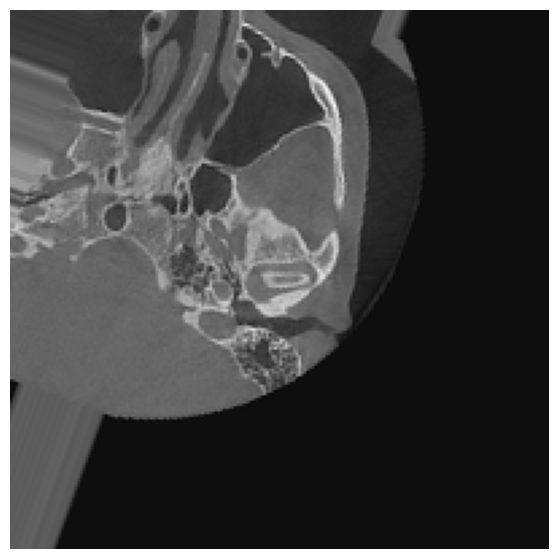

In [123]:
# АКСИАЛЬНЫЙ

# СДВИГ вправо и вниз, чтобы центр картинки попал на мыщелок
np_images_shift = shift_axis_right_3d(np_images, shift_bottom, shift_right)
# # Поворот массива вокруг оси X. В ЦЕНТРЕ - мыщелок.
np_images_rot_A = rotate_3d_array(np_images_shift, 160, axis=1) # 0 -смотрит вправо, 180 -влево. В НАШЕМ случае - 160.

# Поворот и срез
coord_x = round(np_images.shape[0] * (415/722))
coord_y = round(np_images.shape[1] * (520/800))
coord_z = round(np_images.shape[2] * (235/800))

# Извлечение среза

slice_1 = np_images_rot_A[coord_x, :, :] # аксиальный (сверху)
# slice_1 = np_images[:, 520, :] # корональный (спереди/фас)
# slice_1 = np_images_rotX[:, :, coord_z] # сагитальный (сбоку/профиль)
# Поворот среза на 90 градусов против часовой стрелки
slice_1 = np.rot90(slice_1)

plt.figure(figsize=(7, 7))
plt.imshow(np.flipud(slice_1.T), cmap='gray')  # Поворот для корректной ориентации
plt.axis('off')
plt.show()

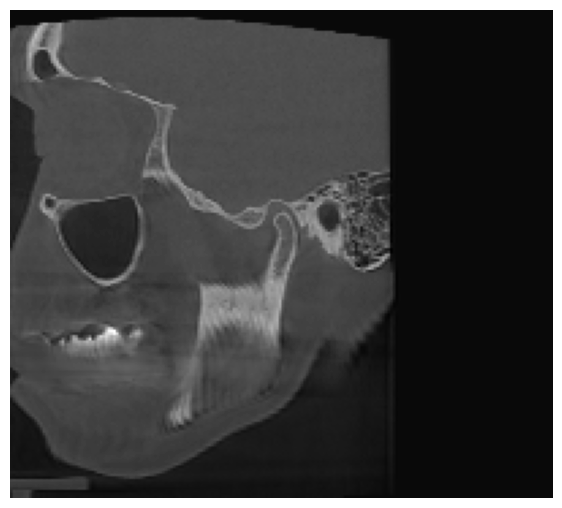

In [124]:
# САГИТТАЛЬНЫЙ

# # Поворот массива вокруг оси X
#np_images_rotX = rotate_3d_array(np_images, 153, axis=1) # 0 -смотрит вправо, 180 -влево

# Поворот и срез
coord_x = round(np_images.shape[0] * (415/722))
coord_y = round(np_images.shape[1] * (520/800))
coord_z = round(np_images.shape[2] * (235/800)) + 40 # подобранный вручную коэффициент (40)

# Извлечение среза
# slice_1 = np_images[415, :, :] # аксиальный (сверху)
# slice_1 = np_images[:, 520, :] # корональный (спереди/фас)
slice_1 = np_images_rot_A[:, :, coord_z] # сагитальный (сбоку/профиль)
# Поворот среза на 90 градусов против часовой стрелки
slice_1 = np.rot90(slice_1)

plt.figure(figsize=(7, 7))
plt.imshow(np.flipud(slice_1.T), cmap='gray')  # Поворот для корректной ориентации
plt.axis('off')
plt.show()

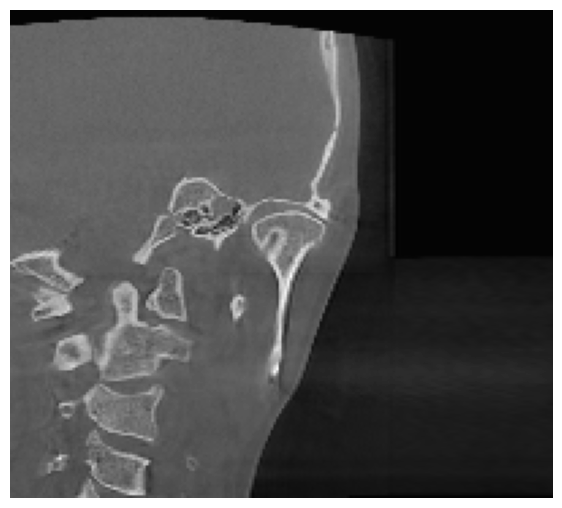

In [125]:
# КОРОНАЛЬНЫЙ
# # Поворот массива вокруг оси X
# np_images_rotX = rotate_3d_array(np_images, 155, axis=1) # 0 -смотрит вправо, 180 -влево

# Поворот и срез
coord_x = round(np_images.shape[0] * (415/722))
coord_y = round(np_images.shape[1] * (520/800)) - 30 # подобранный вручную коэффициент (30)
coord_z = round(np_images.shape[2] * (235/800))

# Извлечение среза
# slice_1 = np_images[415, :, :] # аксиальный (сверху)
slice_1 = np_images_rot_A[:, coord_y, :] # корональный (спереди/фас)
# slice_1 = np_images_rotX[:, :, coord_z] # сагитальный (сбоку/профиль)
# Поворот среза на 90 градусов против часовой стрелки
slice_1 = np.rot90(slice_1)

plt.figure(figsize=(7, 7))
plt.imshow(np.flipud(slice_1.T), cmap='gray')  # Поворот для корректной ориентации
plt.axis('off')
plt.show()

In [13]:
slice_1.dtype

dtype('int16')

In [8]:
np_images.shape[0], np_images.shape[1], np_images.shape[2]

(180, 200, 200)

In [9]:
coord_x, coord_y, coord_z

(103, 130, 59)